# Section 1: Business Understanding

About 10 years ago Asian Basketball was dominated by 3 countries: China, Iran, Lebanon. But With the addition of Australia and New Zealand to the Asian FIBA Zone in the past decade, they've been dominating the continent. Here we'll take a closer look at Asian Basketball through last 4 FIBA official tournaments available with play-by-play files and find the answer for the following questions.

#### Question 1: How Asian Teams Are Playing Currently? 

#### Question 2: Why Teams Need to Abandon Mid-Range Attempts?

#### Question 3: How Team’s Were Playing Before?

#### Question 4: How to Know When to Stop?

# Section 2: Data Understanding

All data has been collected from official tournaments websites on https://www.fiba.basketball/
FIBA collects game stats on server via on-premise staticians using the FIBA LiveStats Software
Data for international events for each game is saved on FIBA official website

for project convenience files has been collected before, and aggregated in excel files for simplifications
Excel Files has been put in Data folder categorized by tournaments
Games File contain teams game by game stats
Logos Folder contain flag of each country, labeled by abbreviated names for illustration purposes

### Gather Data



Importing appropriate libraries and Loading required Files and fucntions

In [252]:
import matplotlib.pyplot as plt
import json
import pandas as pd
from matplotlib.ticker import AutoMinorLocator
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
%matplotlib inline

# using list index for convenience 
tours = ['2019  FIBA, Asian Qualifiers', '2019  FIBA, World Cup', '2022  FIBA, Asia Cup', '2023  FIBA, Asian Qualifiers']


# Loading Appropriate Files
# Raw Play-By-Play File
playByPlay = pd.read_excel(".\Data\Sample pbp file.xlsx")


# Tournaments Aggregated Average Stats File
average = pd.read_excel(f".\Data\Average.xlsx")


# takes time as String, returns time as float number
def timeToNumber(time):
    """
    returns a float number for the string found at time variable
    
    input:
            time: passed string variable
    
    output:
            converted float number of input time string variable
    """
    
    m, s = [int(x) for x in time.split(':')]
    return m + round(s/60,2)


# Reads Json file .txt from Data Folder
def jsonopener(file):
    """
    returns json file for the path found at file
    
    input:
            file: name of the json file
    
    output:
            loaded json file from the data directory of input file name
    """
    
    with open(f".\Data\\{file}.txt", 'r') as json_file:
        data = json.load(json_file)
    return data


# Gets image Path and Changes Image Zoom depending on the Tournament
def getImage(path, i):
    
    """
    returns zoomed in version of the image found at path
    
    input:
            path: a path to the image file, i: the index of the tournament in the defined list above
    
    output:
            image: processed image of input image file
    """
    
    if i == 0:
        ## 2019 - FIBA, Asian Qualifiers, China
        return OffsetImage(plt.imread(path), zoom = 0.006)
    elif i == 1:
        ## 2019 - FIBA, World Cup, China
        return OffsetImage(plt.imread(path), zoom = 0.08)
    else:
        ## 2022 - FIBA, Asia Cup, Indonesia
        ## 2023 - FIBA, World Cup, Asian Qualifiers
        return OffsetImage(plt.imread(path), zoom = 0.2)
    

# Receives DataFrame with Teams Average, Returns Attempt percentage Related Columns data frame along with colmns and factors list
def pointsCalculator(data):
    
    """
    returns dt dataframe for the dataframe found at data, 
            cols list containing indicators name list, 
            factors list containing dataframe columns name list
    
    input:
            data: loaded Teams Average Excel file as dataframe
    
    output:
            dt: processed pandas dataframe of input dataframe for teams points percentage
    """
    
    dt = pd.DataFrame(data[['Team', 'PTS', 'MidRangePTS', 'PaintPTS', '3PM', 'FTM']])

    dt['MidRangePTS'] = round(dt['MidRangePTS'] / dt['PTS'] * 100)
    dt['PaintPTS'] = round(dt['PaintPTS'] / dt['PTS'] * 100)
    dt['3PTS'] = dt['3PM'] * 3
    dt['3PTS'] = round(dt['3PTS'] / dt['PTS'] * 100)
    dt['FT PTS'] = round(dt['FTM'] / dt['PTS'] * 100)

    dt = dt[['Team', 'PTS', 'MidRangePTS', 'PaintPTS', '3PTS', 'FT PTS']]

    cols = ['MidRange Share', 'Paint Share', '3P Share', 'FT Share']
    factors = ['MidRangePTS', 'PaintPTS', '3PTS', 'FT PTS']

    return dt, cols, factors


# Receives DataFrame with Teams Average, Returns points Related Columns data frame along with colmns and factors list
def attemptsCalculator(data):
    
    """
    returns dt dataframe for the dataframe found at data, 
            cols list containing indicators name list, 
            factors list containing dataframe columns name list
    
    input:
            data: loaded Teams Average Excel file as dataframe
    
    output:
            dt: processed pandas dataframe of input dataframe for teams attempts percentage
    """
    
    dt = pd.DataFrame(data[['Team', 'MidRangeA', 'PaintA', '3PA', 'FTA', 'FGA']])

    dt['FGA'] = dt['FGA'] + dt['FTA']

    dt['MidRangeA'] = round(dt['MidRangeA'] / dt['FGA'] * 100)
    dt['PaintA'] = round(dt['PaintA'] / dt['FGA'] * 100)
    dt['3PA'] = round(dt['3PA'] / dt['FGA'] * 100)
    dt['FTA'] = round(dt['FTA'] / dt['FGA'] * 100)

    cols = ['MidRange Attempts', 'Paint Attempts', '3P Attempts', 'FT Attempts']
    factors = ['MidRangeA', 'PaintA', '3PA', 'FTA']
    
    dt = dt[['Team', 'MidRangeA', 'PaintA', '3PA', 'FTA']]
    return dt, cols, factors

# Section 3: Data Preparation

### Clean Data

First step is cleaning the play-by-play file. This file containts every occurred action happened from starting time of the game to ending time.

GT and score column are dropped as they have no purpose, GT stands for Game Time which is the game time on scoreboard at the moment of each action but it's incorrect so we drop it and use Time column instead. Score is removed because it's redundant SA and SB columns serve as the tracker of score for TeamA and TeamB at any given time. 

FIBA uses abbreviations, different styles of game tracking, we transform and simplify data for calculation purposes
Sample Game File has been put in the project directory.

Time Chron column has been added based on Time column but in float number format to be used in calculations or visualizations.

Players and Teams names are coded with predefined IDs, here we use metadata provided by FIBA to replace team and player IDs with the actual names.

!! both of 2019 Tournaments games play-by-play files has a PId missing column, PId is the previous Id of two consecutive basektball actions. we'll replace it based on the previous actions.

Finally, for this analysis play-by-play is only used to calculate paint and midrange attempts which is already done in the Games.xlsx file due to missing values in 2019 tournaments.

In [16]:
# Refines original Play-By-Play File
def pbp(df):
    
    """
    returns cleaned df dataframe for the dataframe found at df
    
    input:
            df: loaded Play-By-Play dataframe file
    
    output:
            df: cleaned pandas dataframe of input dataframe file 
    """
    
    # Loading Game File
    game = jsonopener(f'sample Game')
    team = game['content']['full']['Competitors']

    # Loading the Number of Periods in the Game
    try:
        game = game['content']['full']['Periods']
    except KeyError:
        # Catches the error for file past 2022
        game = game['content']['full']['ScoreList']

    # Loading the Competition Details
    data = jsonopener(f'sample Compdetails')
    compdetail = data['content']['full']['Competitors']

    # Dropping Useless Columns
    df.drop('GT', inplace=True, axis=1)
    df.drop('Score', inplace=True, axis=1)

    # Reseting index to start from 0
    df.reset_index(inplace=True)

    # Inserting a New Column "Time Chron", to show chronological time, placed at 7th position
    df.insert(7, 'Time Chron', 0)

    # Converting Countdown Scoreboard time to game real time starting from 0:00 to 10:00
    for ct, timet in enumerate(df['Time']):
        c = timet.find(':')
        a = timet[:c]
        b = timet[c + 1:]
        if timet == '10:00':
            df.loc[ct, "Time"] = '0:00'
        else:
            if timet == '00:00':
                df.loc[ct, "Time"] = '10:00'
            elif 60 - int(b) == 60:
                df.loc[ct, "Time"] = f'{9 - int(a) + 1}:0{0}'
            elif len(str(60 - int(b))) < 2:
                df.loc[ct, "Time"] = f'{9 - int(a)}:0{60 - int(b)}'
            else:
                df.loc[ct, "Time"] = f'{9 - int(a)}:{60 - int(b)}'

    # Convering time from String MM:SS to float by Minutes
    for x, tm in enumerate(df['Time']):
        df.loc[x, 'Time Chron'] = timeToNumber(tm)

    # Cleaning Time, to covert to chronological, 0 - 40 Minutes in a new column Time Chron
    dt = list(df.loc[df['AC'].isin(['ENDP'])].index.values)
    z = 0
    for y, indval in enumerate(df['Time Chron']):
        if dt[0] < y:
            if len(dt) > 1:
                dt.pop(0)
                z += 1
        tmp = indval + 10 * z
        df.loc[y, 'Time Chron'] = round(tmp, 2)

    # Cleans T1, Team Names Replacing ID with Actual Team Names
    for i in [0, 1]:
        team_code = team[i]['TeamCode']
        teamid = team[i]['Id']
        df.loc[df['T1'] == teamid, 'T1'] = team_code
        compdetail.pop(team[i]['Id'])

    # Cleans C1, Replacing ID with Actual Player Names
    for id in compdetail:
        pfname = compdetail[id]['FirstName']
        plname = compdetail[id]['Name']
        df.loc[df['C1'] == id, 'C1'] = f'{pfname} {plname}'

    # Cleans Abbreviations in the Data
    # Dictionary providing Abbreviated Words
    dic = {'P3': '3P', 'P2': '2P',
           'LU': 'Layup', 'DU': 'Dunk', 'AO': 'Alley-Oop', 'DL': 'Driving Layup', 'HS': 'Hook Shot',
           'TJ': 'Turnaround Jumpshot', 'PJ': 'Pull-up Jumpshot', 'SJ': 'Step-Back Jumpshot',
           'FL': 'Floating Jumpshot', 'FA': 'Fadeaway Jumpshot',
           'D': 'Defensive', 'O': 'Offensive',
           'SC': 'Second Chance', 'FB': 'Fastbreak',
           'TO': 'Turnover', 'OB': 'Out of Bounds', 'BP': 'Bad Pass', 'DD': 'Double Dribble', 'TR': 'Travel',
           'LB': 'Ball Handling', 'VI': 'Back Court',
           'P': 'Personal Foul', 'SF': 'Shooting Foul', 'U': 'Unsportmanlike', 'T': 'Technical',
           'TC': 'Coach Technical', 'ST': 'Steal'}

    # Replaces JS as jumpshot with 2P or 3P to specify shot value
    for x, it in enumerate(df['Z3']):
        if it == 'JS':
            df.loc[x, "Z3"] = df.loc[x, 'AC']

    # Replaces Abbriviations in Z1, Z2, Z3 as provided in dictionary above
    for k in dic:
        df.loc[df['Z3'] == k, 'Z3'] = dic[k]
        df.loc[df['Z2'] == k, 'Z2'] = dic[k]
        df.loc[df['Z1'] == k, 'Z1'] = dic[k]


    # Replacing 'AL' with Second Chance
    df.loc[df['Z2'] == 'AL', 'Z2'] = 'Second Chance'


    # Replacing +/- values in SU column with 1/0,
    df.loc[df['SU'] == '+', 'SU'] = 1
    df.loc[df['SU'] == '-', 'SU'] = 0

    # Removing index column
    df.drop('index', inplace=True, axis=1)

    # Reseting index to replace the previous dropped one
    df.reset_index(inplace=True)

    # Adding Q column to indicate Quarter
    df['Q'] = 0
    x = 0
    p = 1
    tmp = df.loc[df['Action'].isin(['End of Period'])].index
    for ind in tmp:
        for i in range(x, ind + 1):
            df.loc[i, 'Q'] = p
        p += 1
        x = ind + 1
    df.loc[df.iloc[-1]['index'], 'Q'] = p - 1

    # Fixing RFOUL Z2 column, adding number of FT awarded to the foul receiver
    sfouls = df.loc[df['AC'].isin(['FOUL']) & ~df['Z2'].isin([''])]
    for ind, z2 in zip(sfouls['index'], sfouls['Z2']):
        df.loc[ind + 1, 'Z2'] = z2

    ## Replacing 0 values instead of B in older file format past 2022
    df.loc[df.loc[df['SU'].isin(['B'])].index, 'SU'] = 0

    ## Adding PId (Previous Id) for each necessary actions in files past 2022
    if 'PId' not in df.columns:
        df['PId'] = None

        # Fixing Offensive Fouls PId
        offtodf = df.loc[df['AC'].isin(['FOUL']) & df['Z1'].isin(['Offensive'])]
        df.loc[offtodf.index + 1, 'Z1'] = df.loc[offtodf.index, 'Z1'].values
        for ind in offtodf.index:
            df.loc[ind + 1, 'PId'] = df.loc[ind, 'Id']

        # Fixing Turnovers and Steals
        temp_df = df.loc[df['AC'].isin(['TO', 'ST'])]
        times = temp_df['Time Chron'].drop_duplicates()
        for tm in times:
            df_new = temp_df[temp_df['Time Chron'] == tm]
            if len(df_new) > 1:
                tdf = temp_df[temp_df['Time Chron'] == tm]
                ind = tdf[tdf['AC'] == 'ST']['Id'].index
                df.loc[ind, 'PId'] = tdf[tdf['AC'] == 'TO']['Id'].values[0]

        # Fixing Fouls and Received Fouls PId
        temp_df = df.loc[df['AC'].isin(['RFOUL', 'FOUL'])]
        times = temp_df['Time Chron'].drop_duplicates()
        for tm in times:
            df_new = temp_df[temp_df['Time Chron'] == tm]
            if len(df_new) > 1:
                tdf = temp_df[temp_df['Time Chron'] == tm]
                ind = tdf[tdf['AC'] == 'RFOUL']['Id'].index
                df.loc[ind, 'PId'] = tdf[tdf['AC'] == 'FOUL']['Id'].values[0]

        # Fixing Assisted Shots PId
        temp_df = df.loc[df['AC'].isin(['P2', 'P3', 'ASS'])]
        times = temp_df['Time Chron'].drop_duplicates()
        for tm in times:
            df_new = temp_df[temp_df['Time Chron'] == tm]
            if len(df_new) > 1:
                tdf = temp_df[temp_df['Time Chron'] == tm]
                ind = tdf[tdf['AC'] == 'ASS']['Id'].index
                if tdf['AC'].values[0] == 'P2':
                    df.loc[ind, 'PId'] = tdf[tdf['AC'] == 'P2']['Id'].values[0]
                elif tdf['AC'].values[0] == 'P3':
                    df.loc[ind, 'PId'] = tdf[tdf['AC'] == 'P3']['Id'].values[0]

        # Fixing Blocked Shots PId
        temp_df = df.loc[df['AC'].isin(['BS', 'P2', 'P3'])]
        times = temp_df['Time Chron'].drop_duplicates()
        for tm in times:
            df_new = temp_df[temp_df['Time Chron'] == tm]
            if len(df_new) > 1:
                tdf = temp_df[temp_df['Time Chron'] == tm]
                ind = tdf[tdf['AC'] == 'BS']['Id'].index
                if tdf['AC'].values[0] == 'P2':
                    df.loc[ind, 'PId'] = tdf[tdf['AC'] == 'P2']['Id'].values[0]
                elif tdf['AC'].values[0] == 'P3':
                    df.loc[ind, 'PId'] = tdf[tdf['AC'] == 'P3']['Id'].values[0]

        # Fixing JB (Jumpball) in Actions column (AC)
        df.loc[df[df['AC'] == 'JB'].index.values, 'PId'] = df.loc[df['AC'].isin(['JS'])]['Id'].values[0]


        # Fixing Rebounds and Team Rebounds PId
        temp_df = df.loc[(df['AC'].isin(['P2', 'P3']) & df['SU'].isin([0])) | (df['AC'].isin(['FT']) & (df['Z1'] == df['Z2']) & df['SU'].isin([0]))]
        testdf = pd.DataFrame(columns=['index', 'AC', 'Action', 'Id', 'Time', 'Z1', 'Z2', 'Time Chron', 'Z3', 'C1', 'SA', 'SB', 'T1','SU', 'SX', 'SY', 'R', 'Q', 'PId'])
        for ind in temp_df['index']:
            testdf.loc[ind] = temp_df.loc[ind]

            if (df.loc[ind + 1]['AC'] == 'REB') or (df.loc[ind + 1]['AC'] == 'TREB'):
                df.loc[ind + 1, 'PId'] = temp_df.loc[ind, 'Id']

            elif (df.loc[ind + 2]['AC'] == 'REB') or (df.loc[ind + 2]['AC'] == 'TREB'):
                df.loc[ind + 2, 'PId'] = temp_df.loc[ind, 'Id']

            try:
                if (df.loc[ind + 3]['AC'] == 'REB') or (df.loc[ind + 3]['AC'] == 'TREB'):
                    df.loc[ind + 3, 'PId'] = temp_df.loc[ind, 'Id']
            except KeyError:
                continue

    # Adding Offensive Attribute in Z1 for the consecutive action
    offtodf = df.loc[df['AC'].isin(['FOUL']) & df['Z1'].isin(['Offensive'])]
    df.loc[offtodf.index + 1, 'Z1'] = df.loc[offtodf.index, 'Z1'].values

    # Exporting the Results in an Excel File in Project Directory
    print(df.head())

pbp(playByPlay)

   index      AC           Action  Id  SA  SB  Time  Time Chron   Z1   Z2  \
0      0  STARTG    Start of Game   1   0   0  0:00        0.00  NaN  NaN   
1      1  STARTP  Start of Period   2   0   0  0:00        0.00  NaN  NaN   
2      2      JS              NaN   4   0   0  0:00        0.00  NaN  NaN   
3      3      JB              NaN   5   0   0  0:01        0.02  NaN  NaN   
4      4      JB              NaN   6   0   0  0:01        0.02  NaN  NaN   

    Z3          C1   T1  PId   SU  SX  SY  Q  
0  NaN         NaN  NaN  NaN  NaN NaN NaN  1  
1  NaN         NaN  NaN  NaN  NaN NaN NaN  1  
2  NaN         NaN  NaN  NaN  NaN NaN NaN  1  
3  NaN     Qi Zhou  CHN  4.0    1 NaN NaN  1  
4  NaN  Thon Maker  AUS  4.0    0 NaN NaN  1  


# Section 4: Evaluate the Results

## Question 1: How Asian Teams Are Playing Currently?

Before making visualizations here we calculate Average Statistics for teams and players from game by game files for each tournament

In [17]:
# Reads Games File, Returns Teams Average Stats Excel file
def teamMean(file):
    
    """
    returns data dataframe containing teams average stats based on 
    
    input:
            file: loaded Games Excel file as dataframe
    
    output:
            data: processed pandas dataframe of Games excel file in the given tournament directory
    """
    
    cols = ['Team', 'Id', 'W%', 'PTS', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', '2PM', '2PA', '2P%',
            'FTM', 'FTA', 'FT%', 'DR', 'OR', 'TR', 'AST', 'TO', 'STL', 'BLK', 'PF', 'PFD', 'Bench', 'MidRangePTS',
            'MidRangeM', 'MidRangeA', 'MidRange%', 'PaintPTS', 'PaintM', 'PaintA', 'Paint%', 'W/L']
    
    data = pd.DataFrame(columns=cols[:-1])

    teams = file.drop_duplicates('Team')['Team']

    for ind, tm in enumerate(teams):
        accu = file[file['Team'] == tm]
        temp = accu[cols[3:-1]]
        data.loc[ind] = round(temp.mean(), 2)

        data.loc[ind, 'Team'] = tm
        data.loc[ind, 'Id'] = accu['Id'].values[0]
        gp = accu['Id'].count()
        data.loc[ind, 'GP'] = gp
        w = len(accu['W/L'].loc[accu['W/L'].isin(['W'])])
        data.loc[ind, 'W'] = w
        data.loc[ind, 'L'] = len(accu['W/L'].loc[accu['W/L'].isin(['L'])])
        data.loc[ind, 'W%'] = round(w / gp * 100, 2)
    print(data.head())
    
    
    
# Set i from 0 to 3, to choose the approrpiate tournament
i = 0


# Raw Teams game by game Stats File
games = pd.read_excel(f".\Data\\{tours[i]}\Games.xlsx")


teamMean(games)

  Team     Id     W%    PTS    FGM    FGA    FG%   3PM    3PA    3P%  ...  \
0  AUS   T_16  83.33  87.92  33.00  66.83  49.91  9.75  25.25  38.13  ...   
1  IRI  T_879  66.67  74.17  27.25  67.42  40.65  6.25  23.50  26.60  ...   
2  JPN   T_85  66.67  82.33  29.92  63.00  47.70  6.75  18.08  35.69  ...   
3  KAZ  T_739  33.33  69.00  23.75  59.75  39.84  9.08  25.50  34.98  ...   
4  PHI  T_122  58.33  80.83  29.42  67.67  43.45  7.58  24.25  31.21  ...   

   MidRangeM  MidRangeA  MidRange%  PaintPTS  PaintM  PaintA  Paint%    GP  \
0       1.25       3.75      34.54     44.00   22.00   37.83    0.59  12.0   
1       4.08      12.08      31.71     33.83   16.92   31.83    0.52  12.0   
2       5.50      14.00      38.61     35.33   17.67   30.92    0.57  12.0   
3       2.83       9.25      30.41     23.67   11.83   25.00    0.48  12.0   
4       3.75      10.33      34.77     36.17   18.08   33.08    0.54  12.0   

      W    L  
0  10.0  2.0  
1   8.0  4.0  
2   8.0  4.0  
3   4.0 

To have an understanding of the current situation in Asia first we'll take a look at different attempt categories (Mid-Range, Paint, 3-Point, Free Throws)

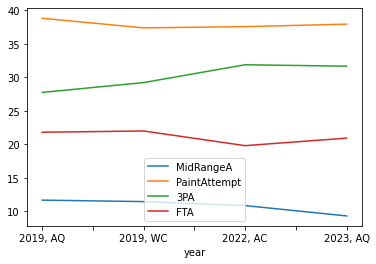

In [270]:
# Plotting Total Attempts in different Tournaments with Line Chart
def linePlotter(data):
    
    """
    returns line chart with png format for the given tournament directory
    
    
    input:
            data: loaded total attempts Excel file as dataframe
    
    output:
            plot: a bar chart with png format of teams total attempts excel file in the given tournament directory
    """
    data = data[['MidRangeA', 'PaintAttempt', '3PA', 'FTA', 'year']]
    data = data.groupby('year').mean()
    data.plot()
    plt.show()
linePlotter(average)

As per other research, starting from 2019 we see a surge in taken 3-Point shots and a decline in the number of Mid-Range Shots Attempted. Paint attempts and Free Throw Attempts has been fairly maintained. This similar pattern has been spotted in modern basketball played in most leagues in the world.

To have a better understanding of how teams are playing, we'll plot histograms of different shot categories through the last two tournaments in 2022 and 2023. Observing teams scoring priorities and percentage of total attempts including Free Throws (Field Goals Attempted + Free throws Attempted).

<Figure size 432x288 with 0 Axes>

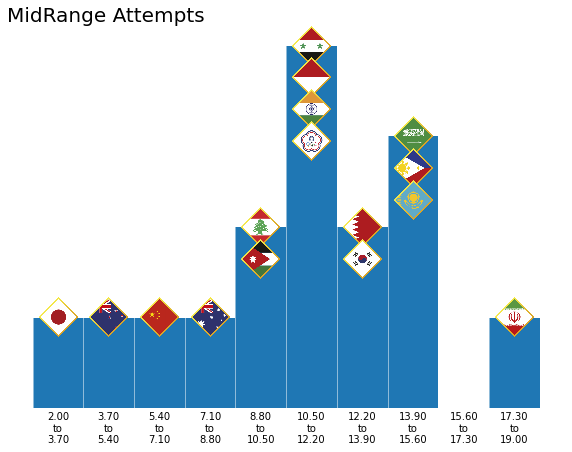

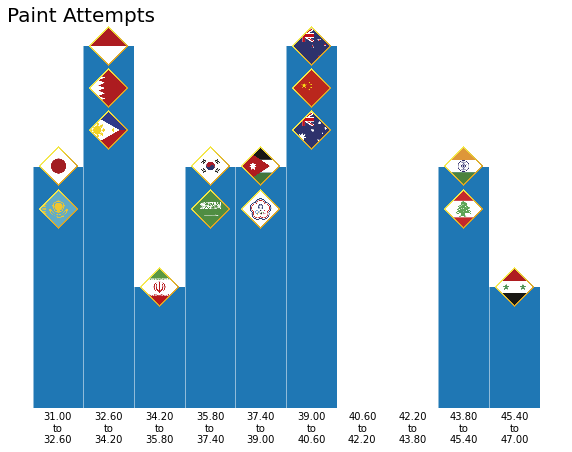

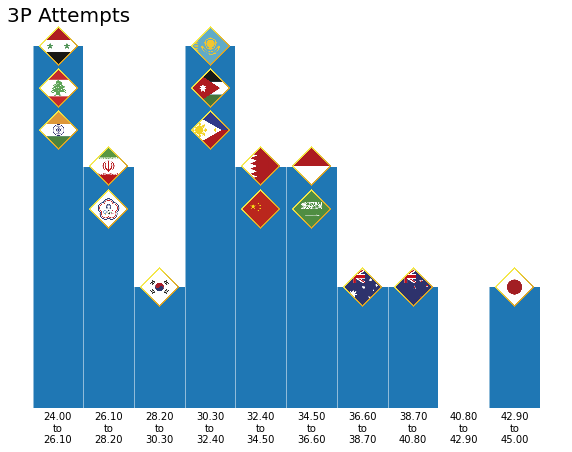

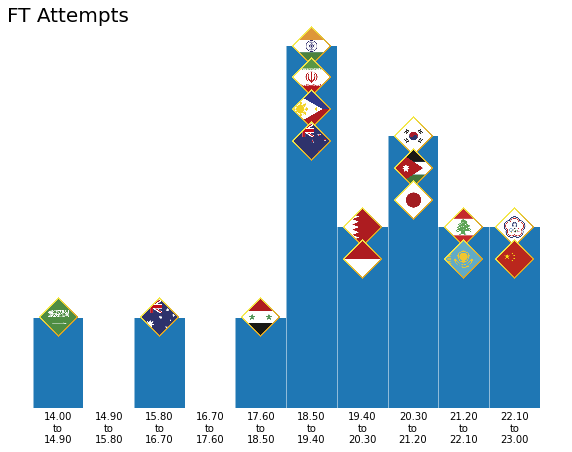

In [271]:
# Uses Attempts and Points Calculators Data to Plot Histograms for each indicator individually and shows it at the end
# Adds the flag of every country as label
def histogramPlotter(data, cols, factors):
    
    """
    returns labeled bar chart with png format for the given tournament directory
    
    
    input:
            data: df: loaded Teams Average Excel file as dataframe
    
    output:
            plot: a bar chart with png format of teams average excel file in the given tournament directory
    """

    plt.clf()
    for factor, col in zip(factors, cols):

        fig, ax = plt.subplots(1, figsize=(10, 7))

        data.sort_values(factor, inplace=True)
        n, bins, patches = plt.hist(data[factor])

        # grid
        minor_locator = AutoMinorLocator(2)
        plt.gca().xaxis.set_minor_locator(minor_locator)
        plt.grid(which='minor', color='white', lw=0.5)  # x ticks
        xticks = [(bins[idx + 1] + value) / 2 for idx, value in enumerate(bins[:-1])]
        xticks_labels = ["{:.2f}\nto\n{:.2f}".format(value, bins[idx + 1]) for idx, value in enumerate(bins[:-1])]
        plt.xticks(xticks, labels=xticks_labels)

        # remove major and minor ticks from the x axis, but keep the labels
        ax.tick_params(axis='x', which='both', length=0)

        # remove y ticks
        plt.yticks([])  # Hide the right and top spines
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        prev = 0
        for (idx, value), bn in zip(enumerate(n), bins[1:]):
            tms = data.loc[(data[factor] >= prev) & (data[factor] < bn)]['Team'].values

            pad = 0
            for tm in tms:
                path = f'.\Data\Logos\\{tours[i]}\\{tm}.png'
                ab = AnnotationBbox(getImage(path, i), (xticks[idx], value - pad), frameon=False)
                ax.add_artist(ab)
                pad += 0.35
            prev = bn

        tms = data.loc[(data[factor] >= prev) & (data[factor] <= bn)]['Team'].values

        for tm in tms:
            path = f'.\Data\Logos\\{tours[i]}\\{tm}.png'
            ab = AnnotationBbox(getImage(path, i), (xticks[idx], value - pad), frameon=False)
            ax.add_artist(ab)
            pad += 0.35

        plt.title(f'{col}', loc='left', fontsize=20)
        plt.show()

            
# Set i from 0 to 3, to choose the approrpiate tournament
i = 2


# Raw Teams Average Stats File
teamsAverage = pd.read_excel(f".\Data\\{tours[i]}\Teams Average.xlsx")

attemptsData, cols, factors = attemptsCalculator(teamsAverage)
    
histogramPlotter(attemptsData, cols, factors)

to find the top teams in the latest Asia Cup tournament. We'll filter out only the teams than won 80% or more of their games. Then we'll take a look at their attempts share per category to better understand how the winners are scoring.

In [272]:
winners = teamsAverage[teamsAverage['W%'] >= 80]['Team'].values
filtered_data = attemptsData.loc[attemptsData['Team'].isin(winners)]
filtered_data2 = filtered_data[filtered_data.columns[1:]]
fitered_data2 = filtered_data2.mean()
fitered_data2.sort_values(ascending=False, inplace=True)
print(fitered_data2)

PaintA       40.25
3PA          33.00
FTA          19.50
MidRangeA     7.75
dtype: float64


Here we can observe, 2022 FIBA Asia Cup winners are scoring 40% from Paint, 33% from 3-Pointer, 19% from Free throws, and 8% from Mid-Range which is the lowest.

We'll run the same process for 2023 FIBA World Cup Asian Qualifiers

<Figure size 432x288 with 0 Axes>

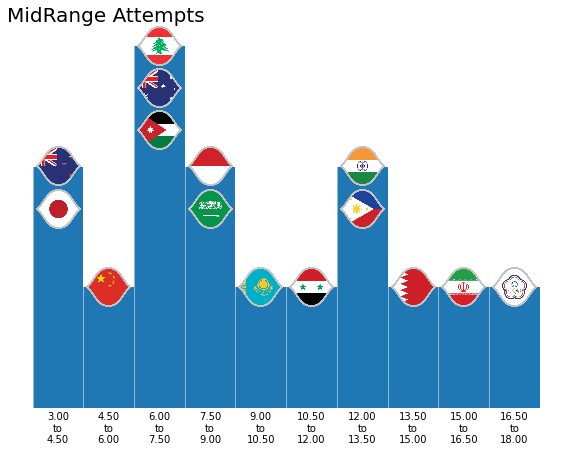

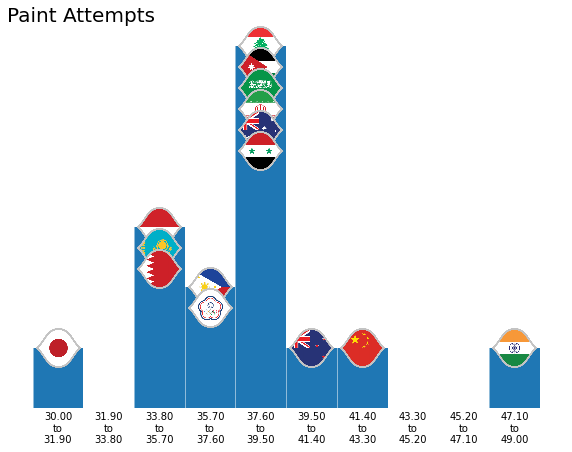

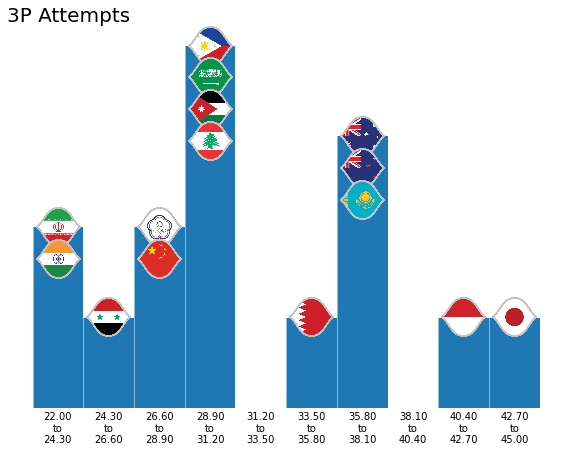

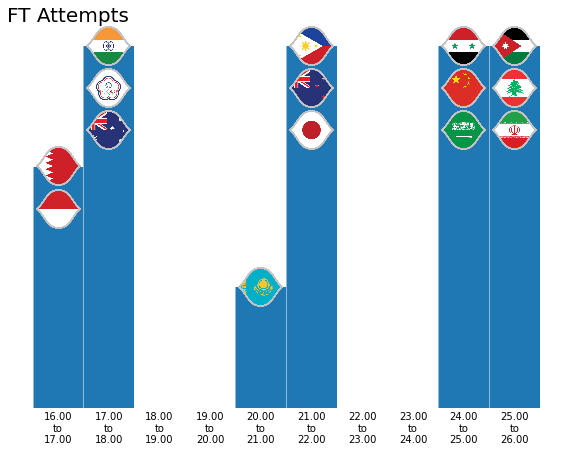

In [273]:
# Set i from 0 to 3, to choose the approrpiate tournament
i = 3

# Raw Teams Average Stats File
teamsAverage = pd.read_excel(f".\Data\\{tours[i]}\Teams Average.xlsx")

attemptsData, cols, factors = attemptsCalculator(teamsAverage)
    
histogramPlotter(attemptsData, cols, factors)

In [274]:
winners = teamsAverage[teamsAverage['W%'] >= 80]['Team'].values
filtered_data = attemptsData.loc[attemptsData['Team'].isin(winners)]
filtered_data3 = filtered_data[filtered_data.columns[1:]]
filtered_data3 = filtered_data3.mean()
filtered_data3.sort_values(ascending=False, inplace=True)
print(filtered_data3)

PaintA       37.75
3PA          35.00
FTA          20.75
MidRangeA     6.25
dtype: float64


2023 FIBA World Cup Asian Qualifiers' winners are scoring 38% from Paint, 35% from 3-Pointer, 21% from Free throws, and 6% from Mid-Range which again is the lowest.

<AxesSubplot:>

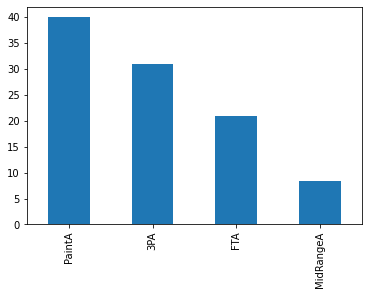

In [275]:
averageStats = pd.concat([fitered_data2, fitered_data3])
averageStats = averageStats.groupby(level=0).mean()
averageStats.sort_values(ascending=False, inplace=True)
averageStats.plot.bar()

In This part we took a look at how teams played at the last 2 FIBA international tournaments, we saw that teams are attempting: 1-Paint, 2- 3-Pointer, 3- Free Throw, 4- Mid-Range

In the above section, we can see the average of these two tournaments to conclude the winners play style currently in Asia. We'll see the same pattern and percentage of each attempts category.

## Question 2: Why Teams Need to Abandon Mid-Range Attempts?

To answer this question, first we should calculate each attempt category's yield per shot. We do so by using Average file then we'll plot the findings.

<AxesSubplot:>

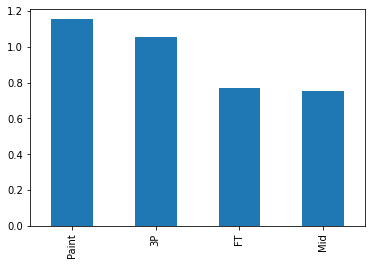

In [173]:
average = average.groupby('year').mean()
df = pd.DataFrame()
df['Paint'] = round(average['PaintPTS'] / average['PaintAttempt'],2)
df['Mid'] = round(average['MidRangePTS'] / average['MidRangeA'],2)
df['3P'] = round(average['3PTS'] / average['3PA'],2)
df['FT'] = round(average['FT PTS'] / average['FTA'],2)
df = df.mean()
df.sort_values(ascending=False, inplace=True)
df.plot.bar()

Using the last 4 tournaments data, we can conclude here that Mid-Range attempts has the lowest points yield per shot among different scoring categories.

## Question 3: How Team’s Were Playing Before?

For checking teams play style in the past, the latest tournament accessible with play-by-ply files were used the 2019 FIBA World Cup and Asian Qualifiers. We will calculate Winners and Losers stats in both tournaments.

In [277]:
# Set i from 0 to 3, to choose the approrpiate tournament
i = 0


# Raw Teams Average Stats File
teamsAverage = pd.read_excel(f".\Data\\{tours[i]}\Teams Average.xlsx")

attemptsData, cols, factors = attemptsCalculator(teamsAverage)

#histogramPlotter(attemptsData, cols, factors)

In [278]:
winners = teamsAverage[teamsAverage['W%'] >= 80]['Team'].values
filtered_data = attemptsData.loc[attemptsData['Team'].isin(winners)]
filtered_data0 = filtered_data[filtered_data.columns[1:]]
fitered_data0 = filtered_data0.mean()
fitered_data0.sort_values(ascending=False, inplace=True)
print('Winners\n')
print(fitered_data0, '\n')

Winners

PaintA       39.666667
3PA          29.000000
FTA          22.333333
MidRangeA     9.000000
dtype: float64 



Here we perform the same process for World Cups 2019

In [279]:
# Set i from 0 to 3, to choose the approrpiate tournament
i = 1


# Raw Teams Average Stats File
teamsAverage = pd.read_excel(f".\Data\\{tours[i]}\Teams Average.xlsx")

attemptsData, cols, factors = attemptsCalculator(teamsAverage)

#histogramPlotter(attemptsData, cols, factors)

In [280]:
winners = teamsAverage[teamsAverage['W%'] >= 80]['Team'].values
filtered_data = attemptsData.loc[attemptsData['Team'].isin(winners)]
filtered_data1 = filtered_data[filtered_data.columns[1:]]
fitered_data1 = filtered_data1.mean()
fitered_data1.sort_values(ascending=False, inplace=True)
print(fitered_data1)

PaintA       35.5
3PA          31.5
FTA          25.5
MidRangeA     7.5
dtype: float64


<AxesSubplot:>

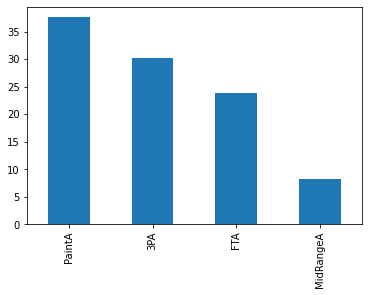

In [281]:
pastAverageStats = pd.concat([fitered_data0, fitered_data1])
pastAverageStats = pastAverageStats.groupby(level=0).mean()
pastAverageStats.sort_values(ascending=False, inplace=True)
pastAverageStats.plot.bar()

After examination of 2 previous events back in 2019, we can see the same scoring priority pattern in winners, due to having more games in World Cup we can see even a bigger difference between Mid-Range and rest of the categories.

## Question 4: How to Know When to Stop?

In this last section, to understand how many attempts from different categories would be considered too many, we'll first take a look at Winners stats in 2019 World Cup then compare it to Losers in the same tournament.

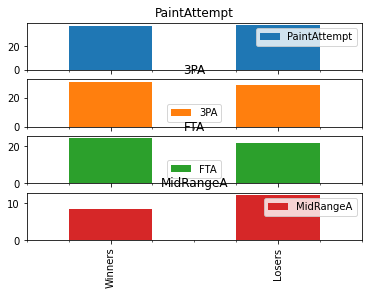

In [305]:
# Filtering the World Cup 2019
wcdata = average[average['year'] == '2019, WC']

# Defining needed columns
cols = ['3PA', 'PaintAttempt', 'MidRangeA', 'FTA']

# Filtering out Winners with 75% or more wins
winners = wcdata[wcdata['W%'] >= 75][cols]
winners = winners.mean()
winners.sort_values(ascending=False, inplace=True)

# Calculating stats for Losers with less than 75% wins
losers = wcdata[wcdata['W%'] < 75][cols]
losers = losers.mean()
losers.sort_values(ascending=False, inplace=True)


combined = pd.DataFrame(data=(winners, losers), index=['Winners', 'Losers'])
axes = combined.plot.bar(subplots=True)

Comparison between Winners and Losers in World Cup 2019, shows that Winners are attempting more from Paint area and 3-Pointers, less Mid-Range as it yields the least points per shot. Also we can see How losing Asian teams were playing which shows they rely on Mid-Range more than they should comparing to winners in Asia.